## Melanoma Detection using a Custom CNN Model

### Introduction
In this assignment, we aim to build a multiclass classification model using a custom convolutional neural network (CNN) in TensorFlow. The goal is to accurately detect melanoma, a potentially deadly type of skin cancer that accounts for 75% of skin cancer deaths. By creating a solution to automatically evaluate images and alert dermatologists to the presence of melanoma, we can reduce the manual effort required in diagnosis and improve early detection outcomes.

The dataset consists of 2357 images representing various malignant and benign oncological diseases, sourced from the International Skin Imaging Collaboration (ISIC). It contains nine disease classes: 

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

We will build a CNN-based multiclass classification model following a structured pipeline with custom model architecture (without transfer learning), image augmentation, and class imbalance handling.

### Project Pipeline

1. **Data Reading and Understanding**
   - Define the path for training and testing images.
   - Load and explore the data to understand its structure and contents.

2. **Dataset Creation**
   - Create training and validation datasets from the train directory.
   - Set a batch size of 32 and resize all images to 180x180 pixels.

3. **Dataset Visualization**
   - Visualize one sample image from each of the nine classes to better understand the data.

4. **Model Building & Initial Training**
   - Build a custom CNN model with appropriate layers for multiclass classification.
   - Normalize image pixel values to a range between 0 and 1.
   - Select an optimizer and loss function suitable for multiclass classification.
   - Train the model for approximately 20 epochs.
   - Assess and summarize model performance, checking for overfitting or underfitting.

5. **Data Augmentation**
   - If signs of overfitting or underfitting appear, apply data augmentation techniques to improve model generalization.

6. **Model Training on Augmented Data**
   - Retrain the CNN model with the augmented dataset.
   - Repeat the normalization, optimizer, and loss function selection steps.
   - Train the model for approximately 20 epochs.
   - Summarize findings and assess if augmentation addressed the overfitting/underfitting issues.

7. **Class Distribution Analysis**
   - Analyze the current class distribution in the training dataset.
   - Identify the class with the fewest samples and the dominant classes in terms of sample count.

8. **Handling Class Imbalance**
   - Use the Augmentor library to address any class imbalances found in the training dataset.

9. **Model Training on Balanced Data**
   - Retrain the CNN model with the balanced dataset created with Augmentor.
   - Ensure images are normalized and the optimizer/loss function is appropriately selected.
   - Train the model for approximately 30 epochs.
   - Summarize the outcomes and assess if the balancing strategy resolved previous issues.

In [75]:
# Import libraries for file handling and data visualization
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image

## 1. Data Reading and Understanding

In [76]:
# Define directory paths for train and test datasets
train_dir = './data/Train'
test_dir = './data/Test'


In [ ]:
# Collect all image paths from the train and test directories
train_image_paths = glob(os.path.join(train_dir, '**', '*.jpg'), recursive=True)
test_image_paths = glob(os.path.join(test_dir, '**', '*.jpg'), recursive=True)

# Print the total number of images
print(f"Total training images: {len(train_image_paths)}")
print(f"Total test images: {len(test_image_paths)}")


In [ ]:
# Extract class names from the train directory structure
train_classes = sorted([d.name for d in os.scandir(train_dir) if d.is_dir()])
test_classes = sorted([d.name for d in os.scandir(test_dir) if d.is_dir()])

# Verify class consistency between train and test sets
assert train_classes == test_classes, "Train and Test classes do not match!"
print(f"Classes: {train_classes}")


In [ ]:
# Function to display a sample image from each class
def display_sample_images(image_paths, classes):
    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(classes):
        sample_image_path = next((path for path in image_paths if class_name in path), None)
        if sample_image_path:
            image = Image.open(sample_image_path)
            plt.subplot(3, 3, i + 1)
            plt.imshow(image)
            plt.title(class_name)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images from the training set
display_sample_images(train_image_paths, train_classes)


In [ ]:
# Count the number of images per class in the training set
train_class_counts = {class_name: len(glob(os.path.join(train_dir, class_name, '*.jpg'))) for class_name in train_classes}

# Plot the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in Training Set')
plt.show()


## 2. Dataset Creation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parameters
batch_size = 32
img_height = 180
img_width = 180

# ImageDataGenerator with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2   # Ensure validation split is the same in both generators
)

# ImageDataGenerator for validation (no augmentation, only rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2   # Ensure validation split is the same in both generators
)

# Training generator, using 80% of the data in train_dir
train_generator = train_datagen.flow_from_directory(
    directory='./data/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use subset for training
)

# Validation generator without augmentation, using 20% of the data in train_dir
validation_generator = validation_datagen.flow_from_directory(
    directory='./data/Train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use subset for validation
)


In [ ]:

# Test generator without augmentation (no label shuffling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    directory='./data/Test',            # Path to the test directory
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False                       # Keep the test set intact
)

In [ ]:

# Inspecting the generators to check image shapes and augmentations
sample_training_images, sample_training_labels = next(train_generator)
print("Training Batch Image Shape:", sample_training_images.shape)
print("Training Batch Label Shape:", sample_training_labels.shape)

sample_validation_images, sample_validation_labels = next(validation_generator)
print("Validation Batch Image Shape:", sample_validation_images.shape)
print("Validation Batch Label Shape:", sample_validation_labels.shape)

sample_test_images, sample_test_labels = next(test_generator)
print("Test Batch Image Shape:", sample_test_images.shape)
print("Test Batch Label Shape:", sample_test_labels.shape)


## 3. Dataset Visualization
 

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images from each class
def plot_sample_images(generator, class_names, num_classes=9):
    plt.figure(figsize=(12, 12))
    
    # Dictionary to track images per class
    class_image_dict = {class_name: None for class_name in class_names}
    
    # Loop through the batches until we have one image per class
    for images, labels in generator:
        # Loop through images in the batch
        for img, label in zip(images, labels):
            # Get the class index of the image
            class_idx = np.argmax(label)
            class_name = class_names[class_idx]
            
            # If we don't yet have an image for this class, add it
            if class_image_dict[class_name] is None:
                class_image_dict[class_name] = img
        # Check if we have collected all classes
        if all(img is not None for img in class_image_dict.values()):
            break
    
    # Plot one image per class
    for idx, (class_name, img) in enumerate(class_image_dict.items()):
        ax = plt.subplot(3, 3, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
class_names = list(train_generator.class_indices.keys()) # Get class labels from the generator
plot_sample_images(train_generator, class_names) # plot one image of each class

In [ ]:
class_names = list(validation_generator.class_indices.keys()) # Get class labels from the generator
plot_sample_images(validation_generator, class_names) # plot one image of each class

In [ ]:
class_names = list(test_generator.class_indices.keys()) # Get class labels from the generator
plot_sample_images(test_generator, class_names) # plot one image of each class

## 4. Model Building & Initial Training

In [88]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    # Input layer to define the input shape
    layers.Input(shape=(180, 180, 3)),
    
    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening Layer
    layers.Flatten(),

    # Fully Connected Dense Layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer for regularization
    layers.Dense(9, activation='softmax')  # 9 classes for multiclass classification
])

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary to review layer details
model.summary()

In [94]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    # workers=4,                 # Number of worker processes
    # use_multiprocessing=True,  # Enables multiple processes for data loading
    # max_queue_size=10          # Sets max size for the generator queue
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 401ms/step - accuracy: 0.2859 - loss: 1.9170 - val_accuracy: 0.2957 - val_loss: 1.9607
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6694 - val_accuracy: 0.5357 - val_loss: 1.6117
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 401ms/step - accuracy: 0.3831 - loss: 1.7415 - val_accuracy: 0.2981 - val_loss: 1.9329
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2812 - loss: 2.1962 - val_accuracy: 0.3571 - val_loss: 1.8069
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.3113 - loss: 1.8630 - val_accuracy: 0.3413 - val_loss: 1.7329
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2812 - loss: 1.7567 - val_accuracy: 0.3571 - val_loss: 1.7707
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 426ms/step - accuracy: 0.4041 - loss: 1.6489 - val_accuracy: 0.3990 - val_loss: 1.8117
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3750 - loss: 1.6472 - val_accuracy: 0.3214

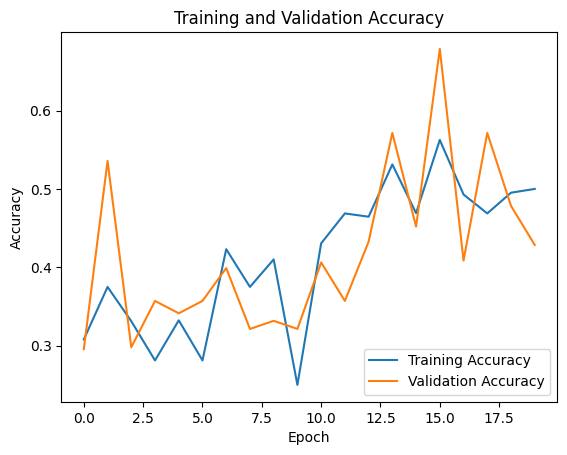

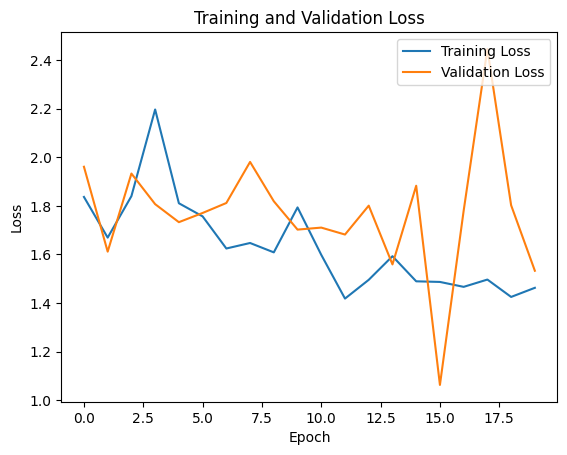

In [95]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Based on the training and validation plots provided, here’s my summary:

1. **Training and Validation Accuracy**: The accuracy plot reveals fluctuations in both the training and validation accuracies, without a clear upward trend. This instability suggests that the model may be struggling to learn consistent patterns from the data. Additionally, the validation accuracy varies significantly, spiking in certain epochs and dropping in others, indicating potential overfitting or issues with the model's capacity to generalize well.

2. **Training and Validation Loss**: The loss plot shows a downward trend in the training loss, suggesting that the model is learning to minimize errors on the training data. However, the validation loss fluctuates considerably, similar to the accuracy plot, with occasional high peaks. This inconsistency between training and validation loss points to overfitting—where the model performs well on training data but struggles with unseen validation data.

3. **Next Steps**:
   - **Adjust Model Architecture**: To improve stability and generalization, I could try simplifying the model by reducing the number of layers or parameters, which might help with overfitting.
   - **Regularization Techniques**: I might also incorporate dropout layers or L2 regularization to mitigate overfitting.
   - **Data Augmentation**: Although we’re already using some data augmentation, adding more diverse transformations could improve the model's ability to generalize.
   - **Learning Rate Tuning**: Adjusting the learning rate or using learning rate scheduling could stabilize training and potentially improve convergence.

These observations suggest that the model needs further tuning to achieve better, more stable generalization across both training and validation sets. Let me know if you'd like me to proceed with these adjustments.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


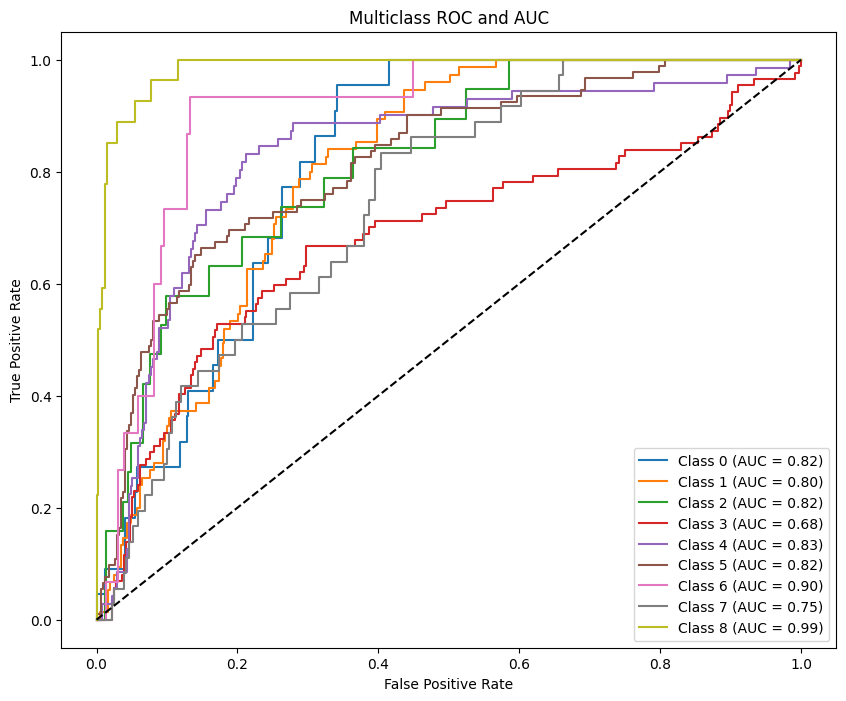

In [96]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare true labels and predicted probabilities
# Get true labels and predictions from the validation generator
y_true = []
y_pred = []

# Loop over the validation generator batches
for i in range(len(validation_generator)):
    X_batch, y_batch = validation_generator[i]
    y_true.extend(y_batch)
    y_pred.extend(model.predict(X_batch))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Binarize the true labels for each class
n_classes = y_true.shape[1]
y_true_binarized = label_binarize(np.argmax(y_true, axis=1), classes=range(n_classes))

# Step 2: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC and AUC')
plt.legend(loc='lower right')
plt.show()


## 5. Data Augmentation
 

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


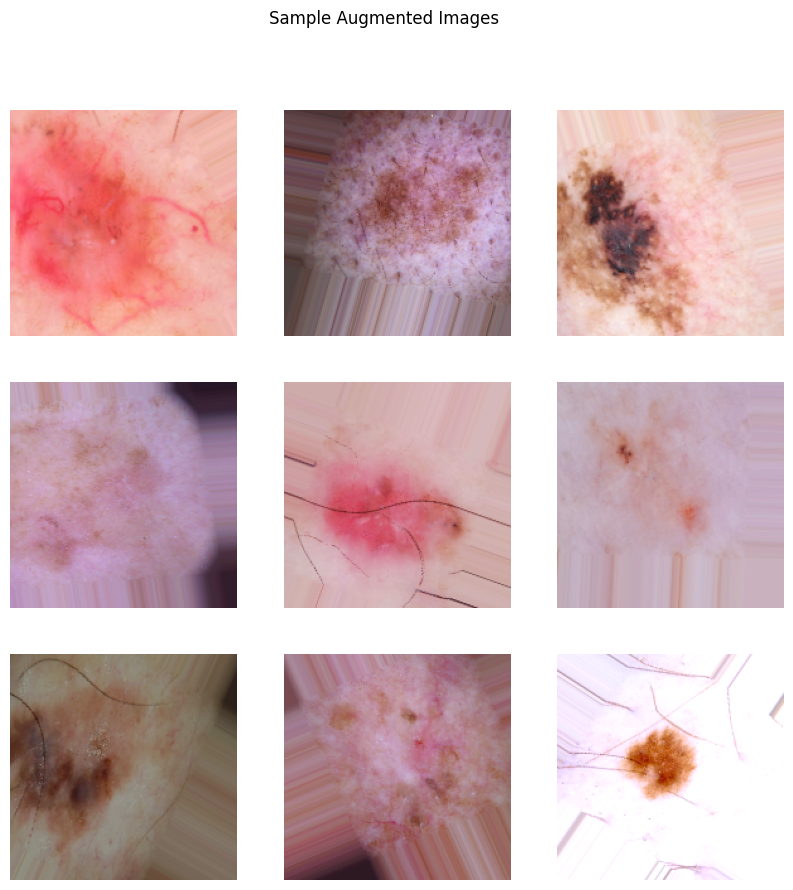

In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Refined data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,                # Normalize pixel values to [0, 1]
    rotation_range=40,                # Increased rotation for more variability
    width_shift_range=0.2,            # Increased horizontal shift
    height_shift_range=0.2,           # Increased vertical shift
    shear_range=0.3,                  # More aggressive shear transformation
    zoom_range=0.3,                   # More aggressive zoom
    horizontal_flip=True,             # Randomly flip images horizontally
    brightness_range=[0.8, 1.2],      # Adjust brightness for more variety
    fill_mode='nearest',              # Fill empty pixels after transformation
)

# Validation data should only be rescaled (no augmentation)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Redefine train and validation generators with updated parameters
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
)

# Display a few augmented images to inspect the transformations
import matplotlib.pyplot as plt

# Get a batch of training data
sample_images, _ = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.suptitle("Sample Augmented Images")
plt.show()


c:\Users\Amit.Mohite\venvs\tensorflow_env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.4416 - loss: 1.6441 - val_accuracy: 0.3438 - val_loss: 2.1306
Epoch 2/20
 1/69 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.4194 - loss: 1.4807

C:\Program Files\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4194 - loss: 1.4807 - val_accuracy: 0.0909 - val_loss: 2.8615
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 394ms/step - accuracy: 0.4679 - loss: 1.4857 - val_accuracy: 0.3333 - val_loss: 2.1918
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5000 - loss: 1.6494 - val_accuracy: 0.0909 - val_loss: 2.6314
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.4976 - loss: 1.4557 - val_accuracy: 0.3333 - val_loss: 2.0951
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3438 - loss: 1.7309 - val_accuracy: 0.0909 - val_loss: 2.7117
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 27s 396ms/step - accuracy: 0.5321 - loss: 1.3492 - val_accuracy: 0.3438 - val_loss: 2.1143
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5625 - loss: 1.2452 - val_accuracy: 0.0909 - val_loss: 3.1406
Epoch 9/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 407ms/step - accuracy: 0.4771 - loss: 1.4492 - val_accuracy: 0.3854 - val_

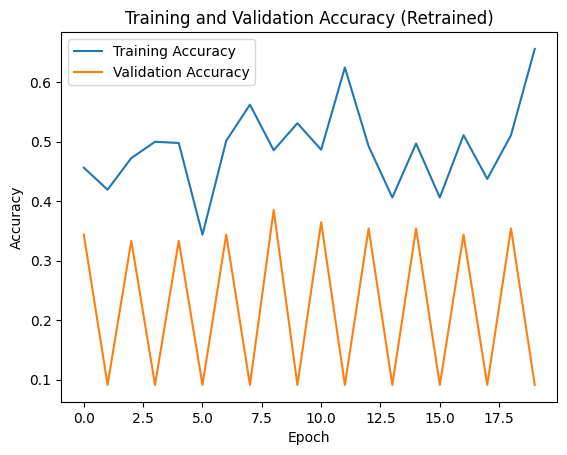

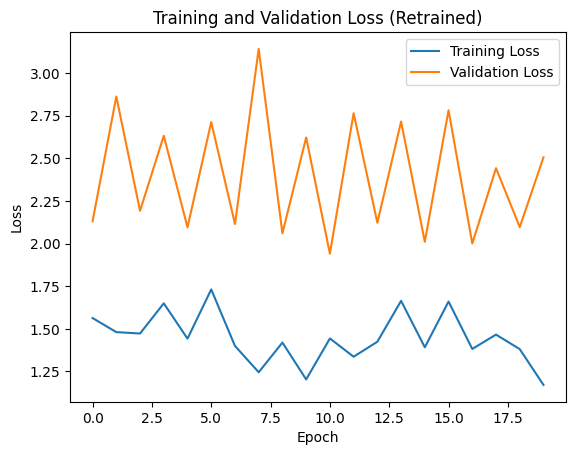

In [98]:
# Compile the model with the same optimizer and loss function
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Retrain the model for 20 epochs, using the updated train and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Retrained)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Retrained)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
